In [9]:
# import modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis

##################################################
# a list with leaf IDs to read in and process data
##################################################

leaf_list = ["VITISRIPARIA_0","VITISRUPESTRIS_0","VITISAESTIVALIS_0","VITISPIASEZKII_0",
             "CABERNETSAUVIGNON_0","CHARDONNAY_0","GEWURTZTRAMINER_0","CHASSELASCIOUTAT_0"]

color_list = ["#a6d854", "#fc8d62", "#ffd92f", "#e78ac3",
                "#8da0cb", "#66c2a5", "#e5c494", "#b3b3b3" ]

#########################################################
# for reference, record numbers of landmarks in this data
#########################################################

num_samples = 8 # record number of samples
vein_len = 1216 # record the number of vein landmarks
blade_len = 855 # record the number of blade landmarks
total_length = 1216+855 # the total number of vein + blade landmarks combined

# print out landmark numbers for reference
print("there are", vein_len, "vein landmarks\nthere are", 
      blade_len, "blade landmarks\nthere are", 
      total_length, "landmarks total")

there are 1216 vein landmarks
there are 855 blade landmarks
there are 2071 landmarks total


# Format data into a list of arrays for each leaf shape

In [10]:
shape_list = [] # a list of arrays for each leaf

for i in range(len(leaf_list)):
    
    curr_leaf = leaf_list[i] # select current leaf
    print(i, curr_leaf) # print current leaf
    
    curr_veins = np.loadtxt("./landmarks/" + curr_leaf + "_scaled_veins.txt") # load in vein landmarks
    curr_blade = np.loadtxt("./landmarks/" + curr_leaf + "_scaled_blade.txt") # load in blade landmarks
    
    curr_veins_blade = np.row_stack((curr_veins, curr_blade)) # stack vein landmarks on top of blade
    
    shape_list.append(curr_veins_blade) # add the stacked vein-blade landmark array to shape_list

0 VITISRIPARIA_0
1 VITISRUPESTRIS_0
2 VITISAESTIVALIS_0
3 VITISPIASEZKII_0
4 CABERNETSAUVIGNON_0
5 CHARDONNAY_0
6 GEWURTZTRAMINER_0
7 CHASSELASCIOUTAT_0


# Calculate mean Generalized Procrustes Analysis (GPA) shape

In [11]:
ref_ind = 0 # select a reference index to calculate procrustes distances to
ref_shape = shape_list[ref_ind] # select the reference shape

mean_diff = 10**(-30) # set a distance between means to stop the algorithm

old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

d = 1000000 # set d initially arbitraily high

while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations
    
    arr = np.zeros( ((len(shape_list)),total_length,2) ) # empty 3D array: # samples, total number of landmarks, 2 coord vals

    for i in range(len(shape_list)): # for each leaf shape after removing outliers

        s1, s2, distance = procrustes(old_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
        arr[i] = s2 # store procrustes adjusted shape to array

    new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference
    
    s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean
    
    print("the Procrustes distance between the old and new mean is", d) # print out difference between mean distance
    
    old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration
    
gpa_mean = new_mean


the Procrustes distance between the old and new mean is 0.030554580110351746
the Procrustes distance between the old and new mean is 1.4244319797704215e-05
the Procrustes distance between the old and new mean is 7.607183186806772e-09
the Procrustes distance between the old and new mean is 4.068954287788129e-12
the Procrustes distance between the old and new mean is 2.1765267251455603e-15
the Procrustes distance between the old and new mean is 1.1642496561905843e-18
the Procrustes distance between the old and new mean is 6.227680046066843e-22
the Procrustes distance between the old and new mean is 3.331757565520638e-25
the Procrustes distance between the old and new mean is 1.787196196901972e-28
the Procrustes distance between the old and new mean is 1.7115215623720444e-31


#### Check the Generalized Procrustes Analysis mean shape

Text(0.5, 1.0, 'Generalized Procrustes Analysis\nMean leaf')

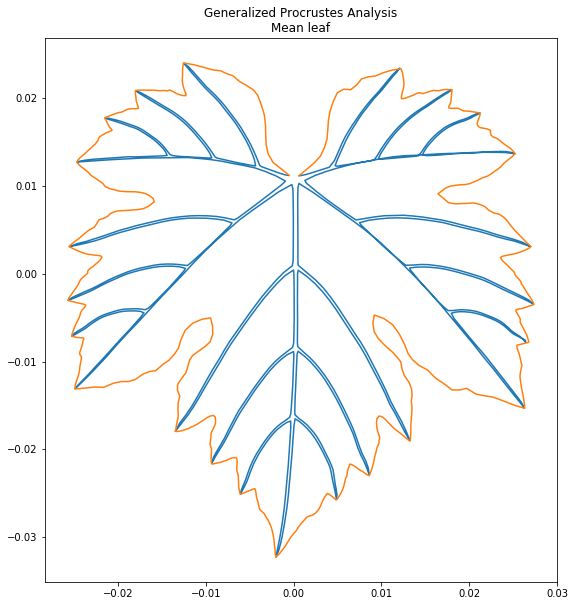

In [12]:
gpa_mean_veins = gpa_mean[0:vein_len,:] # get vein landmarks
gpa_mean_blade = gpa_mean[vein_len:,:] # get blade landmarks

plt.figure(figsize=(10,10)) # plot the mean leaf
plt.plot(gpa_mean_veins[:,0], gpa_mean_veins[:,1])
plt.plot(gpa_mean_blade[:,0], gpa_mean_blade[:,1])
plt.gca().set_aspect("equal")
plt.title("Generalized Procrustes Analysis\nMean leaf")


# Calculate Procrustes-adjusted coordinates for each leaf against the calculated mean

In [13]:
proc_arr = np.zeros( ((len(shape_list)), total_length, 2) ) # empty 3D array: # samples, total landmarks, 2 coord vals

for i in range(len(shape_list)): # for each leaf shape after removing outliers

    s1, s2, distance = procrustes(gpa_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

#### Visually check all Procrustes adjusted leaf shapes, plot with the gpa mean leaf

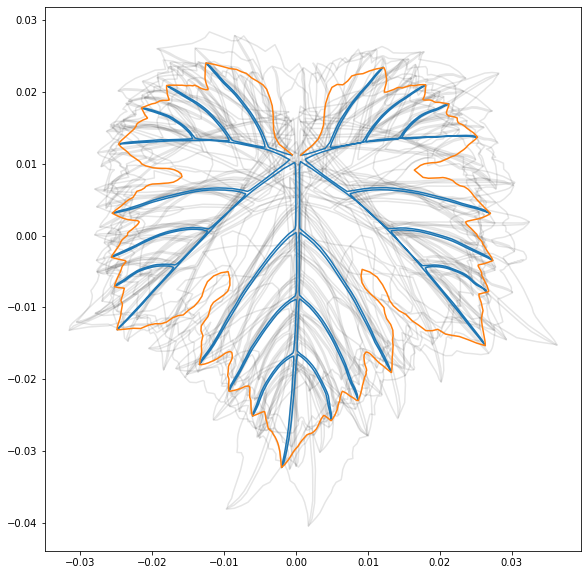

In [14]:
plot_col = "k" # set plot color
a = 0.1 # set alpha

plt.figure(figsize=(10,10))

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]
    
    curr_leaf_veins = curr_leaf[0:vein_len,:] # get vein landmarks
    curr_leaf_blade = curr_leaf[vein_len:,:] # get blade landmarks
    
    plt.plot(curr_leaf_veins[:,0], curr_leaf_veins[:,1], c=plot_col, alpha=a) # plot current leaf with color and alpha
    plt.plot(curr_leaf_blade[:,0], curr_leaf_blade[:,1], c=plot_col, alpha=a)
    plt.gca().set_aspect("equal")
    
plt.plot(gpa_mean_veins[:,0], gpa_mean_veins[:,1]) # plot the mean leaf
plt.plot(gpa_mean_blade[:,0], gpa_mean_blade[:,1])


plt.gca().set_aspect("equal")

# Morphospace and Inverse Principal Component Analysis

#### Find percent variance for each PC

In [15]:
reshaped_arr = proc_arr.reshape(num_samples, total_length*2) # use the reshape function to flatten proc_arr to 2D

test_pca = PCA(n_components=num_samples) # set number of PCs to number of samples
test_PCs = test_pca.fit_transform(reshaped_arr) # fit a PCA

print(test_pca.explained_variance_ratio_) # print out explained variance for each PC
print(test_pca.explained_variance_ratio_.cumsum())


[6.45425119e-01 1.39492511e-01 1.07658041e-01 4.11162556e-02
 2.65479062e-02 2.54373698e-02 1.43227970e-02 2.99542059e-31]
[0.64542512 0.78491763 0.89257567 0.93369193 0.96023983 0.9856772
 1.         1.        ]


#### Create an inverse PCA space and calculate PC points to reconstruct

In [16]:
# define number of desired PCs

pca = PCA(n_components=3)

# apply the sklearn pca function with desired number of components

PCs = pca.fit_transform(reshaped_arr)

# the inverse transform function is applied

inverse_PCA = pca.inverse_transform(PCs)

# calculate min and max PC values

minPC1 = np.min(PCs[:,0])
maxPC1 = np.max(PCs[:,0])
minPC2 = np.min(PCs[:,1])
maxPC2 = np.max(PCs[:,1])
minPC3 = np.min(PCs[:,2])
maxPC3 = np.max(PCs[:,2])

stdPC1 = np.std(PCs[:,0])
stdPC2 = np.std(PCs[:,1])
stdPC3 = np.std(PCs[:,2])

# or, calculate PC intervals based on standard deviation

std_num = 1.3

# calculate PC intervals to reconstruct

interval_num = 7 # select number of intervals to divide each PC axis
PC1_vals = np.linspace(-stdPC1*std_num, stdPC1*std_num, interval_num)
PC2_vals = np.linspace(-stdPC2*std_num, stdPC2*std_num, interval_num)
PC3_vals = np.linspace(-stdPC3*std_num, stdPC3*std_num, interval_num)

#### Reconstruct leaves based on PC values

In [17]:
for p in range(interval_num): # for each PC3 value
    
    PC3_val = PC3_vals[p] # current PC3 value
    
    curr_plot = 0 # restart plot with each PC3 value (PC3 values are like "slices")
    plt.figure(figsize=(20,20)) # create a new plot with each new PC3 value

    
    # create a grid of reconstructed leaves in PC2 vs PC1 for the current PC3 value
    
    for i in range(interval_num): # for each PC1 value

        for j in range(interval_num): # for each PC2 value

            curr_plot += 1 # counter for subplot

            PC1_val = PC1_vals[i] # get current PC1 val
            PC2_val = PC2_vals[j] # get current PC2 val

            # for current PC values, find closest matched leaf and color to plot with
            distances = []

            for s in range(np.shape(PCs)[0]):

                curr_leaf_PCs = PCs[s,:]
                d = np.sqrt((curr_leaf_PCs[0]-PC1_val)**2 + (curr_leaf_PCs[1]-PC2_val)**2 + (curr_leaf_PCs[2]-PC3_val)**2)
                distances.append(d)

            species_match_index = distances.index(min(distances)) # get minimum distance index
            matched_species = leaf_list[species_match_index] # get matched species
            matched_color = color_list[species_match_index] # get matched color

            # plot inverse leaf for current PC vals

            inv_new = pca.inverse_transform(np.array([PC1_val,PC2_val,PC3_val])) # perform inverse PCA
            inv_reshape = inv_new.reshape(total_length, 2) # convert from 3D to 2D array, flattening the x and y coords
            inv_veins = inv_reshape[0:vein_len,:] # get vein landmarks
            inv_blade = inv_reshape[vein_len:,:] # get blade landmarks

            plt.subplot(interval_num,interval_num,curr_plot) # plot the leaf using subplot
            plt.fill(inv_blade[:,0], inv_blade[:,1], c=matched_color)
            plt.fill(inv_veins[:,0], inv_veins[:,1], c="white")
            plt.gca().set_aspect("equal")
            plt.axis("off")
            
    filename = "./morphospace/morphospace_" + str(p) + ".jpg"
    plt.savefig(filename) # save the current PC2 vs PC1 grid for the current PC3 value
    plt.close()



